In [1]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import random

前向传播计算

In [2]:
def feedforward(w,a,x):
    f = lambda s:1/(1+np.exp(-s))
    w = np.array(w)
    temp = np.array(np.concatenate((a,x),axis=0))
    z_next = np.dot(w,temp)
    return f(z_next),z_next

误差方向传播计算

In [3]:
def backprop(w,z,delta_next):
    f = lambda s:np.array(1/(1+np.exp(-s)))
    df = lambda s:f(s)*(1-f(s))
    delta = df(z)*np.dot(w.T,delta_next)
    return delta

导入人脸数据，并进行归一化

In [4]:
DataSet = scio.loadmat('D:/yaleB_face_dataset.mat')
unlabeledData = DataSet['unlabeled_data']
dataset_size = 80#准备的无标签的人脸图片数据数量
unlabeled_data = np.zeros(unlabeledData.shape)
#利用z-score归一化方法归一数据
for i in range(dataset_size):
    tmp = unlabeledData[:,i]/255.
    unlabeled_data[:,i]=(tmp - np.mean(tmp))/np.std(tmp)
    

设置自编码器无监督训练参数，及神经网络结构

In [5]:
alpha = 0.5#学习步长
max_epoch =300#自编码器训练总次数
mini_batch =10#最小批训练时，每次使用10个样本同时进行训练
height =48#人脸数据图片的高度
width = 42#人脸数据图片的宽度
imgSize = height*width

#神经网络结构
hidden_node = 60#网络隐藏层节点数目
hidden_layer = 2
layer_struc = [[imgSize,1],
              [0,hidden_node],
              [0,imgSize]]
layer_num = 3#网络层次数目
#初始化无监督网络的权值
w = []
for l in range(layer_num-1):
    w.append(np.random.randn(layer_struc[l+1][1],sum(layer_struc[l])))
#定义神经网络的外部节点数目
X=[]
X.append(np.array(unlabeled_data[:,:]))
X.append(np.zeros((0,dataset_size)))
X.append(np.zeros((0,dataset_size)))
#初始化在网络训练中，进行误差方向传播所需的delta
delta = []
for l in range(layer_num):
    delta.append([])

从准备好的人脸数据中显示其中每个人的一张图片，原始图片将训练过程中自编码的输出结果展示在同一面板

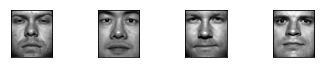

In [6]:
#定义结果展示参数
nRow = max_epoch / 100 + 1
nColumn =4
eachFaceNum = 20 #对于每个人都有20张未标记图像数据
#在第一行中展示原始图像
for iImg in range(nColumn):
    ax = plt.subplot(nRow,nColumn,iImg + 1)
    plt.imshow(unlabeledData[:,eachFaceNum *iImg +1].reshape((width,height)).T,cmap = plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

开始人脸图像自编码器的训练过程：

Autoencoder training start..
Learning epoch: 100 / 300
Learning epoch: 200 / 300
Learning epoch: 300 / 300


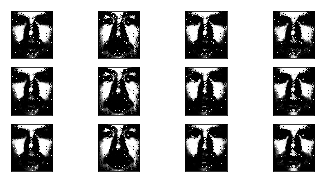

In [7]:
#无监督训练
count = 0#记录训练次数
print('Autoencoder training start..')
for iter in range (max_epoch):
    #定义随机洗牌下标
    ind = list(range(dataset_size))
    random.shuffle(ind)
    a = []
    z = []
    z.append([])
    for i in range(int(np.ceil(dataset_size /mini_batch))):
        a.append(np.zeros((layer_struc[0][1],mini_batch)))
        x = []
        for l in range(layer_num):
            x.append(X[l][:,ind[i*mini_batch : min((i+1)*mini_batch,dataset_size)]])
        
        y= unlabeled_data[:,ind[i*mini_batch:min((i+1)*mini_batch,dataset_size)]]
        for l in range(layer_num-1):
            a.append([])
            z.append([])
            a[l+1],z[l+1] = feedforward(w[l],a[l],x[l])
        
        
        delta[layer_num-1] = np.array(a[layer_num-1]-y) * np.array(a[layer_num -1])
        delta[layer_num-1] = delta[layer_num-1] * np.array(1-a[layer_num -1])
        
        for l in range(layer_num-2,0,-1):
            delta[l] = backprop(w[1],z[1],delta[l+1])
        
        for l in range(layer_num-1):
            dw = np.dot(delta[l+1],np.concatenate((a[l],x[l]),axis=0).T) / mini_batch
            w[l] = w[l] - alpha * dw
    count = count +1
    
    
  #每训练100次展示一次自编码器目前对原始图像的输出结果  
    if np.mod(iter+1,100) == 0 :
        b=[]
        b.append(np.zeros((layer_struc[0][1],dataset_size)))
        
        for l in range(layer_num-1):
            tempA,tempZ = feedforward(w[l],b[l],X[l])
            b.append(tempA)
        for iTmg in range(nColumn):
            ax = plt.subplot(nRow,nColumn,iTmg +nColumn *(iter+1) /100 + 1)
            tmp = b[layer_num -1][:,eachFaceNum *iTmg +1]
            dis_result = ((tmp *np.std(tmp))+np.mean(tmp)).reshape(width,height).T
            plt.imshow(dis_result,cmap=plt.cm.gray)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        print('Learning epoch:',count,'/',max_epoch)
        
        
        
        
        

以上为自编码器的实现，对数据进行降维

In [8]:
from __future__ import division
#定义有监督学习参数
supervised_alpha = 0.3#步长

max_epoch = 10000#训练次数
mini_batch =14
SJ = []#用于保存训练过程的误差变化
SAcc = []#用于记录训练过程中分类器预测的正确率变化过程
#初始化有监督升级网络结构
SL_layer_srtuc = []
SL_layer_num = 2
SL_layer_struc = [[0,hidden_node],[0,4]]
#初始化有监督训练部分神经网络的权值
supervised_weight = []
for l in range(SL_layer_num-1):
    supervised_weight.append(np.random.randn(SL_layer_struc[l+1][1],sum(SL_layer_struc[l])))
    
#用于有监督学习的误差调整时的delta
delta = []
for l in range(SL_layer_num):
    delta.append([])






导入训练集和测试集数据，及其对应的标记数据，并对数据进行归一化

In [9]:
#训练集数据
trainData = DataSet['trainData']
trainData = trainData[:,:]
train_data = np.zeros(trainData.shape)
#归一化处理
trainData_size = 56
for i in range(trainData_size):
    tmp = trainData[:,i]
    train_data[:,i] = (tmp - np.mean(tmp)) / np.std(tmp)
train_labels = DataSet['train_labels']
train_labels = train_labels[:,:]
#测试集数据
testData = DataSet['testData']
testData = testData[:,:]
test_data = np.zeros(testData.shape)
#归一化处理
testData_size =40
for i in range(testData_size):
    tmp = testData[:,i]
    test_data[:,i] = (tmp-np.mean(tmp)) / np.std(tmp)
    
test_labels = DataSet['test_labels']
test_labels = test_labels[:,:]

利用自编码器获取训练集和测试集降维后的编码：

In [10]:
#训练集
a =[]
a.append(np.zeros((layer_struc[0][1],trainData_size)))
for l in range(hidden_layer-1):
    if l==0:
        tmpA,tmpZ = feedforward(w[l],a[l],train_data)
        a.append(tmpA)
    else:
        tmpA,tmpZ = feedforward(w[l],a[l],np.zeros((0,trainData_size)))
        a.append(tmpA)
small_trainData = a[hidden_layer-1]
#测试集
a =[]
a.append(np.zeros((layer_struc[0][1],testData_size)))
for l in range(hidden_layer-1):
    if l==0:
        tmpA,tmpZ = feedforward(w[l],a[l],test_data)
        a.append(tmpA)
    else:
        tmpA,tmpZ = feedforward(w[l],a[l],np.zeros((0,testData_size)))
        a.append(tmpA)
small_testData = a[hidden_layer-1]

有监督训练过程：

In [11]:
def supervised_training():
    global SJ
    global SAcc
    print('Supervised training start..')
    for iter in range(max_epoch):
        #随机从数据集中挑选数据进行训练
        ind = list(range(trainData_size))
        random.shuffle(ind)
        
        a=[]
        z =[]
        z.append([])
        for i in range(int(np.ceil(trainData_size / mini_batch))):
            #网络内部节点
            a.append(small_trainData[:,ind[i*mini_batch:min((i+1)*mini_batch,trainData_size)]])
            #准备网络训练的外部节点
            x=[]
            for l in range(SL_layer_num):
                x.append(np.zeros((0,min((i+1)*mini_batch,trainData_size)-i*mini_batch)))
            #网络的目标输出    
            y=train_labels[:,ind[i*mini_batch:min((i+1)*mini_batch,trainData_size)]]
            #进行网络的前向传播计算    
            for l in range(SL_layer_num-1):
                a.append([])
                z.append([])
                a[l+1],z[l+1] = feedforward(supervised_weight[l],a[l],x[l])
            #计算网络输出与目标输出的误差值        
            delta[SL_layer_num-1] = np.array(a[SL_layer_num-1] -y)*np.array(a[SL_layer_num-1])
            delta[SL_layer_num-1] = delta[SL_layer_num-1]*np.array(1-a[SL_layer_num-1])
                
            #进行误差反向传播    
            for l in range(SL_layer_num-2,0,-1):
                delta[1] = backprop(supervised_weight[l],z[l],dalta[l+1])
                    
                    
            for l in range(SL_layer_num-1):
                dw = np.dot(delta[l+1],np.concatenate((a[l],x[l]),axis=0).T) / mini_batch
                supervised_weight[l] = supervised_weight[l] - supervised_alpha*dw
                    
            tmpResult = a[SL_layer_num-1]
            SJ.append(np.sum(np.multiply(tmpResult[:] - y[:],tmpResult[:]-y[:]))/2/mini_batch)
            SAcc.append(float(sum(np.argmax(y,axis=0) == np.argmax(tmpResult,axis=0))/mini_batch))
    #展示训练过程的预测正确率和误差值变化
    print('Supervised learning done!')
    plt.figure()
    plt.plot(SJ)
    plt.title('loss function')
    plt.figure()
    plt.plot(SAcc)
    plt.title('Accuracy')
                
        
    
    
    
    
    
    
    
    
    

测试有监督训练的结果，输出其对于训练集和测试集的预测正确率：

In [12]:
def supervised_testing():
    print('Testing..')
    #测试对训练集的预测结果正确率
    tmpA,tmpZ = feedforward(supervised_weight[0],small_trainData,np.zeros((0,trainData_size)))
    train_pred = np.argmax(tmpA,axis =0)
    train_res = np.argmax(train_labels,axis=0)
    
    train_acc = float(sum(train_pred == train_res) / trainData_size)*100
    print('Training accuracy:%.2f%c'%(train_acc,'%'))
    #测试对预测集的预测结果正确率
    tmpA,tmpZ = feedforward(supervised_weight[0],small_testData,np.zeros((0,testData_size)))
    test_pred = np.argmax(tmpA,axis=0)
    test_res = np.argmax(test_labels,axis=0)
    test_acc = float(sum(test_pred == test_res) / testData_size)*100
    print('Testing accuracy:%.2f%c'%(test_acc,'%'))

Supervised training start..
Supervised learning done!
Testing..
Training accuracy:100.00%
Testing accuracy:67.50%


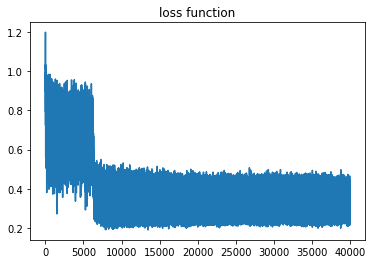

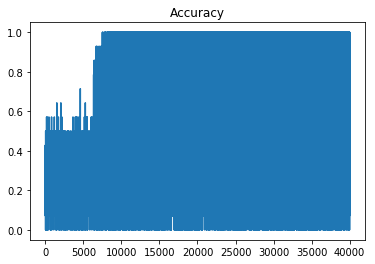

In [13]:
supervised_training()
supervised_testing()
plt.show()